## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [7]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [8]:
cat_attrs = ['home', 'marital', 'records', 'job']
num_attrs = list(filter(lambda s: s not in cat_attrs, df.drop('default', axis=1).columns))

num_attrs

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
from sklearn.model_selection import train_test_split

def train_val_test_split(df):
    train, test = train_test_split(df, random_state=1, test_size=0.2)
    train, val = train_test_split(train, random_state=1, test_size=0.25)
    
    return train.drop('default', axis=1), train['default'], \
           val.drop('default', axis=1), val['default'], \
           test.drop('default', axis=1), test['default']

trainX, trainy, valX, valy, testX, testy = train_val_test_split(df)
trainX

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
1877,12,private,24,28,married,no,fixed,45,102,0,0,700,1229
1803,4,other,60,28,married,no,fixed,60,143,0,0,1150,1630
3400,0,owner,60,27,married,no,fixed,35,295,6000,0,1950,2208
3529,6,owner,48,28,married,no,fixed,45,114,3500,0,650,1255
1721,12,owner,36,42,married,no,freelance,60,0,15000,0,1000,1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,0,rent,48,54,married,no,freelance,135,0,0,0,2000,2476
1956,6,rent,12,33,married,no,fixed,85,250,0,0,500,1500
91,9,parents,60,32,single,yes,fixed,35,105,0,0,1490,1490
3602,0,parents,60,21,single,no,others,35,149,3000,0,1400,1829


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [10]:
from sklearn.metrics import roc_auc_score

scores = [roc_auc_score(trainy, trainX[attr]) for attr in num_attrs]
pd.DataFrame(zip(num_attrs, scores), columns=['attr', 'score']).sort_values('score', ascending=False)

,attr,score
7,amount,0.591077
1,time,0.560866
8,price,0.504333
3,expenses,0.499082
6,debt,0.495217
2,age,0.426707
5,assets,0.351396
4,income,0.317993
0,seniority,0.290622


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

**Answer:** time

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)

trainX_transformed = dv.fit_transform(trainX[columns].to_dict('records'))

log_reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
log_reg.fit(trainX_transformed, trainy)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [12]:
valX_transformed = dv.transform(valX[columns].to_dict('records'))
predictions = log_reg.decision_function(valX_transformed)

roc_auc_score(valy, predictions).round(3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [13]:
actual_positives = (valy == 1)
actual_negatives = (valy == 0)
thresholds = np.linspace(0, 1.0, 101)
predictions = log_reg.predict_proba(valX_transformed)[:, 1] >= 0.5
scores = []

for t in thresholds:
    predict_positives = log_reg.predict_proba(valX_transformed)[:, 1] >= t
    predict_negatives = log_reg.predict_proba(valX_transformed)[:, 1] < t
    
    tp = (predict_positives & actual_positives).sum()
    tn = (predict_negatives & actual_negatives).sum()
    fp = (predict_positives & actual_negatives).sum()
    fn = (predict_negatives & actual_positives).sum()
    
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores, columns='threshold tp tn fp fn'.split(' '))
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

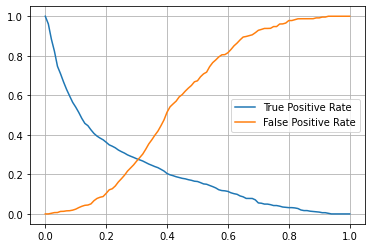

In [19]:
plt.plot(df_scores.threshold, df_scores.tpr, label='True Positive Rate')
plt.plot(df_scores.threshold, df_scores.fpr, label='False Positive Rate')
plt.legend()
plt.grid('both')
plt.show()

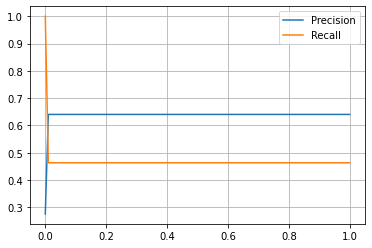

In [21]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 101)

precs = [precision_score(valy, predictions >= t) for t in thresholds]
recs = [recall_score(valy, predictions >= t) for t in thresholds]

plt.plot(thresholds, precs, label='Precision')
plt.plot(thresholds, recs, label='Recall')
plt.legend()
plt.grid('both')
plt.show()

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(valy, log_reg.predict_proba(valX_transformed)[:, 1])
plt.plot(thresholds, precisions[:, 1], label='Precision')
plt.plot(thresholds, recalls[]:, 1], label='Recall')
plt.legend()
plt.grid('both')
plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_4476/3502413199.py, line 5)

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.